In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    print(series)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
print(series)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


[[ 0.45969481  0.3148668   0.12497122 ...  0.13293118 -0.15862932
  -0.35489398]
 [ 0.24511377  0.23174434 -0.00599396 ...  0.41383964  0.29797258
   0.11629631]
 [ 0.28175752  0.36084806  0.39095697 ... -0.51123078 -0.47599973
  -0.35395945]
 ...
 [-0.29076028  0.00447233  0.23519841 ... -0.4157637  -0.09082646
   0.20479946]
 [ 0.32318807  0.53325653  0.62738761 ...  0.56122646  0.43038004
   0.31498623]
 [ 0.15683164  0.11962829 -0.05645954 ...  0.21774583  0.16028289
   0.05052823]]
[[[ 0.4596948 ]
  [ 0.31486678]
  [ 0.12497123]
  ...
  [ 0.13293117]
  [-0.15862931]
  [-0.35489398]]

 [[ 0.24511378]
  [ 0.23174433]
  [-0.00599396]
  ...
  [ 0.41383964]
  [ 0.2979726 ]
  [ 0.11629631]]

 [[ 0.2817575 ]
  [ 0.36084807]
  [ 0.39095697]
  ...
  [-0.51123077]
  [-0.47599974]
  [-0.35395944]]

 ...

 [[-0.29076028]
  [ 0.00447233]
  [ 0.23519841]
  ...
  [-0.4157637 ]
  [-0.09082647]
  [ 0.20479946]]

 [[ 0.32318807]
  [ 0.53325653]
  [ 0.6273876 ]
  ...
  [ 0.5612264 ]
  [ 0.43038005]


In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

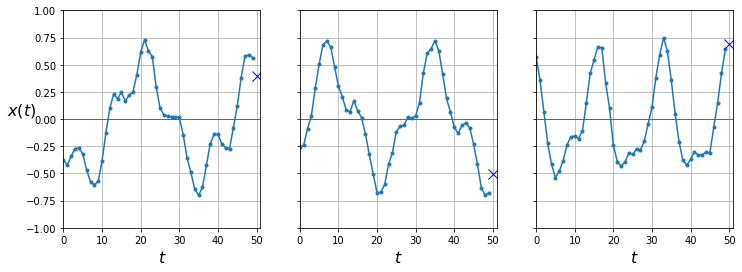

In [5]:

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [6]:
# naive predictions
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

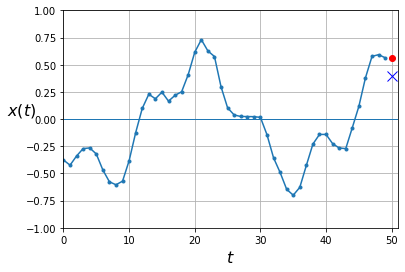

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
# predict linearly
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # expects flat list of features
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 3s 6ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 863us/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 761us/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 812us/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 867us/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 821us/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 826us/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 908us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 784us/step - loss: 0.0063 - 

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 597us/step - loss: 0.0042


0.004168087150901556

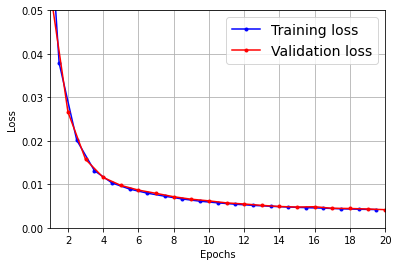

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

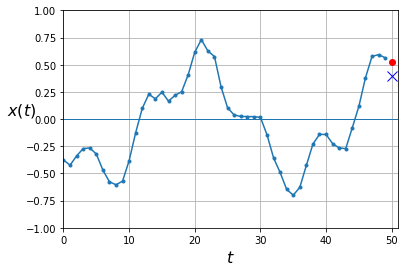

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [12]:
# simple RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0117 - val_loss: 0.0110

In [13]:
model.evaluate(X_valid, y_valid)


63/63 [==============================] - 0s 2ms/step - loss: 0.0109


0.010881561785936356

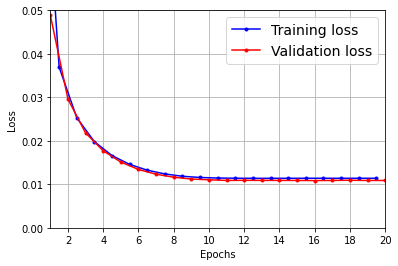

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

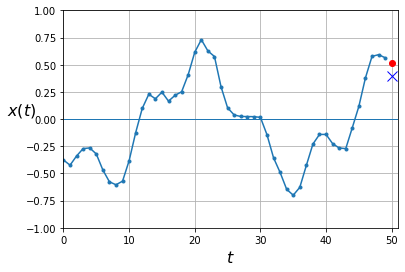

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [16]:
# deep RNNs
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0035 - val_lo

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.002910564187914133

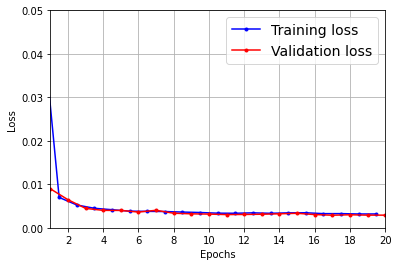

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [19]:
# use Dense layer: faster, roughly same accuracy, and can choose any act. function
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0029 - val_loss: 0.0029

In [20]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0026


0.002623623004183173

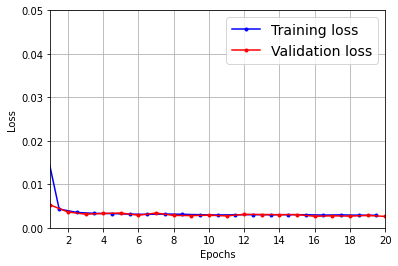

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

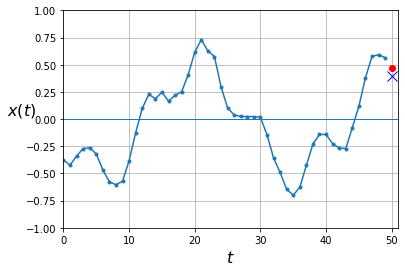

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [23]:
# predict steps ahead

# first try same model & putting output back in
# predict one step at a time
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

[[-0.71430596 -0.60402304 -0.50313396 -0.35858592 -0.24881064 -0.04383381
   0.01058156  0.08940701  0.03474096  0.00100053  0.08181838  0.05386399
   0.15612572  0.2726096   0.39456056  0.60695227  0.7012151   0.74101047
   0.6343575   0.575656    0.36496111  0.21561034  0.00555652 -0.02026231
  -0.13460333 -0.14756192 -0.15892326 -0.09476995 -0.1205122  -0.16748159
  -0.23957133 -0.37922844 -0.50983545 -0.64504992 -0.72317772 -0.67717382
  -0.49088032 -0.38508183 -0.16000109 -0.01318712  0.10783868  0.14367717
   0.22596198  0.14425407  0.14529224  0.2065604   0.22278383  0.27942811
   0.4081502   0.51637863  0.64557175  0.65620269  0.65506254  0.55766188
   0.39075594  0.19883815 -0.0130802  -0.15594869 -0.18422735 -0.26694259]]


In [24]:
Y_pred.shape

(1, 10, 1)

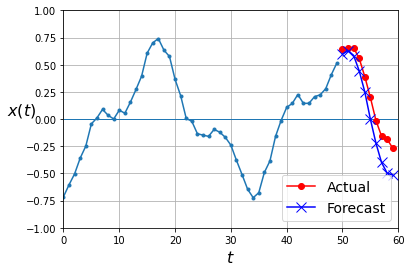

In [25]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [26]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

[[ 0.45969481  0.33874457  0.18980234 ... -0.00905113 -0.18126326
  -0.38846616]
 [ 0.26552482  0.23108747  0.03770885 ...  0.43097195  0.21307838
   0.13890865]
 [ 0.29026951  0.28821456  0.35248583 ... -0.48102695 -0.44013204
  -0.35066979]
 ...
 [-0.30706958 -0.04479904  0.18580438 ... -0.38100747 -0.09274903
   0.20543045]
 [ 0.31035588  0.50322758  0.64256031 ...  0.61418243  0.48535167
   0.28495142]
 [ 0.18452183  0.04713134 -0.05374912 ...  0.1207159   0.11001077
   0.08325014]]


In [27]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [28]:
Y_pred.shape

(2000, 10)

In [29]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510857

In [30]:
# compare with simple linear model
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))


0.22278848

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 833us/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 783us/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 910us/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 815us/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 972us/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 948us/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 949us/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 866us/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 872us/step - loss: 0.0228 

In [32]:
# RNN to predict 10 values all at once
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0118 - val_loss: 0.0100

In [33]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

[[-0.71430596 -0.60402304 -0.50313396 -0.35858592 -0.24881064 -0.04383381
   0.01058156  0.08940701  0.03474096  0.00100053  0.08181838  0.05386399
   0.15612572  0.2726096   0.39456056  0.60695227  0.7012151   0.74101047
   0.6343575   0.575656    0.36496111  0.21561034  0.00555652 -0.02026231
  -0.13460333 -0.14756192 -0.15892326 -0.09476995 -0.1205122  -0.16748159
  -0.23957133 -0.37922844 -0.50983545 -0.64504992 -0.72317772 -0.67717382
  -0.49088032 -0.38508183 -0.16000109 -0.01318712  0.10783868  0.14367717
   0.22596198  0.14425407  0.14529224  0.2065604   0.22278383  0.27942811
   0.4081502   0.51637863  0.64557175  0.65620269  0.65506254  0.55766188
   0.39075594  0.19883815 -0.0130802  -0.15594869 -0.18422735 -0.26694259]]


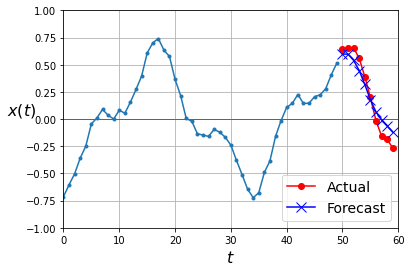

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [36]:
# RNN that predicts next 10 steps at each time step
# turn seq to vector RNN into seq to seq RNN
np.random.seed(42)

# 10 dimensional vector at each step

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

[[ 0.45969481  0.33874457  0.18980234 ... -0.00905113 -0.18126326
  -0.38846616]
 [ 0.26552482  0.23108747  0.03770885 ...  0.43097195  0.21307838
   0.13890865]
 [ 0.29026951  0.28821456  0.35248583 ... -0.48102695 -0.44013204
  -0.35066979]
 ...
 [-0.30706958 -0.04479904  0.18580438 ... -0.38100747 -0.09274903
   0.20543045]
 [ 0.31035588  0.50322758  0.64256031 ...  0.61418243  0.48535167
   0.28495142]
 [ 0.18452183  0.04713134 -0.05374912 ...  0.1207159   0.11001077
   0.08325014]]


In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0367 - val_last_time_step_mse: 0.0267
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0339 - last_time_step_mse: 0.0228 - val_loss: 0.0308 - val_last_time_step_mse: 0.0186
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0297 - last_time_step_mse: 0.0186 - val_loss: 0.0279 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0278 - last_time_step_mse: 0.0163 - val_loss: 0.0268 - val_last_time_step_mse: 0.0167
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0257 - last_time_step_mse: 0.0130 - val_loss: 0.0219 - val_last_time_step_mse: 0.0085
Epoch 7/20
219/219 [========

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

[[-0.71430596 -0.60402304 -0.50313396 -0.35858592 -0.24881064 -0.04383381
   0.01058156  0.08940701  0.03474096  0.00100053  0.08181838  0.05386399
   0.15612572  0.2726096   0.39456056  0.60695227  0.7012151   0.74101047
   0.6343575   0.575656    0.36496111  0.21561034  0.00555652 -0.02026231
  -0.13460333 -0.14756192 -0.15892326 -0.09476995 -0.1205122  -0.16748159
  -0.23957133 -0.37922844 -0.50983545 -0.64504992 -0.72317772 -0.67717382
  -0.49088032 -0.38508183 -0.16000109 -0.01318712  0.10783868  0.14367717
   0.22596198  0.14425407  0.14529224  0.2065604   0.22278383  0.27942811
   0.4081502   0.51637863  0.64557175  0.65620269  0.65506254  0.55766188
   0.39075594  0.19883815 -0.0130802  -0.15594869 -0.18422735 -0.26694259]]


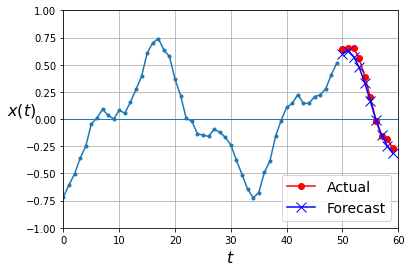

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [41]:
# batch normalization
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [=======

In [42]:
# deep RNN with layer normalization
from tensorflow.keras.layers import LayerNormalization


In [43]:
# behaves like SimpleRNNCell except applies Layer Normalization at each time step
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 24ms/step - loss: 0.2891 - last_time_step_mse: 0.2889 - val_loss: 0.0747 - val_last_time_step_mse: 0.0684
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0697 - last_time_step_mse: 0.0604 - val_loss: 0.0596 - val_last_time_step_mse: 0.0486
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0586 - last_time_step_mse: 0.0489 - val_loss: 0.0531 - val_last_time_step_mse: 0.0417
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0521 - last_time_step_mse: 0.0412 - val_loss: 0.0474 - val_last_time_step_mse: 0.0354
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0467 - last_time_step_mse: 0.0349 - val_loss: 0.0431 - val_last_time_step_mse: 0.0307
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0424 - last_time_step_mse: 0.0294 - val_loss: 0.0382 - val_last_time_step_mse: 0.0247
Epoch 7/20
219/219 [==